In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import pickle as pkl
from collections import defaultdict
from matplotlib import rc
import pandas as pd

In [32]:
# upload multi-content CTR data processed by Yahoo CTR Jupyter Notebook
CTR_data = pkl.load(open("CTR_data.pkl",'rb'))

In [33]:
# reward rates of K=20 arms and T=10^8 rounds (array size: 20*86400000)
CTR_data

array([[0.01454923, 0.01454923, 0.01454923, ..., 0.01366768, 0.01366768,
        0.01366768],
       [0.04838016, 0.04838016, 0.04838016, ..., 0.03480668, 0.03480668,
        0.03480668],
       [0.04996583, 0.04996583, 0.04996583, ..., 0.03996111, 0.03996111,
        0.03996111],
       ...,
       [0.03486695, 0.03486695, 0.03486695, ..., 0.02441029, 0.02441029,
        0.02441028],
       [0.0213767 , 0.0213767 , 0.0213767 , ..., 0.02330745, 0.02330745,
        0.02330745],
       [0.01205352, 0.01205352, 0.01205353, ..., 0.01125636, 0.01125636,
        0.01125636]])

In [34]:
# uniformly extract reward rates of horizon length T/sqrt(2)
T = CTR_data.shape[1]
indices = np.unique(np.floor(np.arange(1, T+1) / np.sqrt(2)).astype(int))
indices

array([       0,        1,        2, ..., 61094023, 61094024, 61094025])

In [35]:
len(indices)

61094026

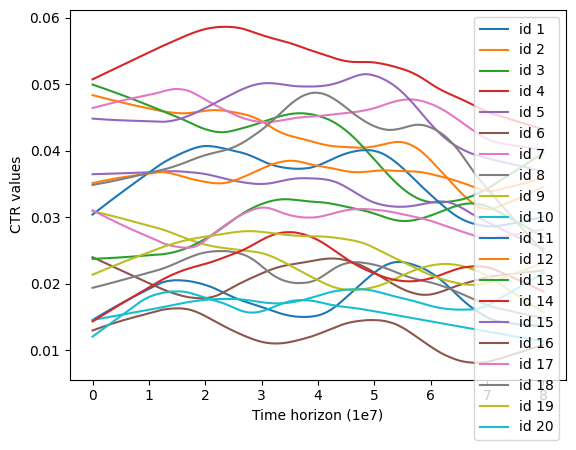

In [5]:
# Create figure and axes
fig, ax = plt.subplots()
K, T = CTR_data.shape

# Plot each line
for i in range(K):
    CTR_sample = CTR_data[i, ::400000]
    ax.plot(np.linspace(0, T, len(CTR_sample)), CTR_sample, label=f'id {i+1}')

# Add legend and labels
ax.legend()
ax.set_xlabel('Time horizon (1e7)')
ax.set_ylabel('CTR values')
x_ticks = np.linspace(0, T, 9)
ax.set_xticks(x_ticks)
x_tick_labels = [f'{int(t/10000000)}' for t in x_ticks]
ax.set_xticklabels(x_tick_labels)

# Show the plot
plt.show()

### Generating reward tapes from reward rates

In [2]:
def Sampling(mean_values, num_trials):
    ''' 
    Generate the Binomial rewards of the changing arm given mean reward rates
    Can be modified to generate Bernoulli rewards and N reward tapes
    input: 
        - mean_value: reward rates of K arms and T rounds (np.array)
        - num_trials: number of customers at each time step (int)
    output: 
        one reward tape (np.array, same dimn as mean_value)
    '''
    # Generate random Binomial rewards based on the rates
    binomial_output = np.random.binomial(n=num_trials, p=mean_values)

    return binomial_output

In [7]:
binomial_rewards = Sampling(mean_values=CTR_data, num_trials=10000)/10000
# pkl.dump(binomial_rewards, open("binomial_rewards.pkl","wb"))

In [24]:
# binomial_rewards = pkl.load(open("binomial_rewards.pkl",'rb'))

In [25]:
binomial_rewards

array([[0.0144, 0.0145, 0.0162, ..., 0.0141, 0.0125, 0.0118],
       [0.0494, 0.0472, 0.0475, ..., 0.0343, 0.0342, 0.0361],
       [0.0506, 0.0504, 0.05  , ..., 0.0444, 0.0409, 0.0399],
       ...,
       [0.0361, 0.0343, 0.0337, ..., 0.0232, 0.025 , 0.0222],
       [0.0233, 0.0198, 0.0221, ..., 0.0254, 0.022 , 0.0216],
       [0.0114, 0.0095, 0.0129, ..., 0.0106, 0.0111, 0.0119]])

### Computing regrets based on OPT and ALG rewards

In [66]:
def Rexp3Protocol(num_arms, gamma, batch_size, rates, tape):
    '''     
    Interaction between the Rexp3 algorithm and the enviornment
    input: 
        - num_arms: number of arms K (int)
        - gamma: exploration probability γ (float between 0 and 1)
        - batch_size: the length of each epoch (batch) Δ_T (int)
        - rates: mean reward rates (np.array)
        - tape: reward tape (np.array)
    output: optimal reward, algorithm reward, regret
    '''

    opt_reward = OPT(rates)
  
    alg_reward = Rexp3(num_arms=num_arms, batch_size=batch_size, gamma=gamma, tape=tape)
    
    regret = opt_reward - alg_reward
    
    return opt_reward, alg_reward, regret

In [62]:
def Protocol(budget, size, rates, tape):
    '''     
    Interaction between the BE algorithm and the enviornment
    input:
        - budget: budget for each epoch B_T (float)
        - size: the length of each epoch Δ_T (int)
        - rates: mean reward rates (np.array)
        - tape: reward tape (np.array)
    output: optimal reward, algorithm reward, regret
    '''

    opt_reward = OPT(rates)
  
    alg_reward = BudgetedExploration(budget, size, tape)
    
    regret = opt_reward - alg_reward
    
    return alg_reward, regret

In [27]:
def OPT(rates):
    '''
    Get the optimal reward of an instance of rates
    input: 
        - rates: mean reward rates (np.array)
    '''

    opt = np.sum(np.max(rates,axis=0))  # recall that the optimal policy receives reward max(E[tape1[t]], E[tape2[t]]) at time t
    
    return opt

### BE algorithm and Rexp3 algorithm (benchmark)

In [28]:
def BudgetedExploration(budget, size, tape):
    ''' 
    Budgeted Exploration Algorithm 
    input:
        - budget: budget for each epoch B (float)
        - size: the length of each epoch Δ (int)
        - tape: reward tape (np.array)
    output: algorithm reward
    
    Original BE Algorithm: 
    - Partition the horizon into epochs of length Δ.  
    - In each epoch, 
        1. reset cum reward = 0 for all arms
        2. round robin over the alive arms
        3. eliminate an arm if its cum reward is lower than that of some other arm by >= B
    
    For computational efficiency, we consider the following twist: 
        In step 2 and 3, instead of doing round robin, with the knowledge of the entire "reward tape", we 
    compute the elimination time of the arms.  
    '''
    num_arms, time_horizon = tape.shape  # K and T
    alg_reward = 0  # total reward collected by BE
    t = 0
    epoch_index = 0
    
    while t < time_horizon:
        k = num_arms  # RESET the number of alive arms in this epoch
        active = np.arange(k)  # indices of active arms in this opech
        epoch_reward = 0 # RESET total rewards collected by BE in this epoch
        cum_rewards = np.zeros(k)  # RESET cumulative rewards of each arm
        tau = 0  # RESET the exploration stopping time in this epoch
        epoch_size = min(size, time_horizon-t)  # due to INTEGRALITY ISSUES, the last epoch may have a smaller size
        epoch_start = t+epoch_size  # start of the next epoch (end of this epoch)
        
        while (epoch_size-tau >= k) and (k > 1):  # while not reach the end of the epoch and more than one arm active
            j = (epoch_size-tau)//k  # number of times each active arm can be pulled in the remaining rounds of this epoch
            explore_rewards = np.zeros([k,j])  # rewards of active arms to be explored
            
            for i in range(k):  # alive arms are pulled in a round-robin manner
                explore_rewards[i] = tape[active[i],t+i:t+k*j:k]
                
            cumsum_rewards = cum_rewards.reshape(k,1)+np.cumsum(explore_rewards, axis=1)  # cumulative sum of rewards of active arms
            diff = np.max(cumsum_rewards,axis=0) - np.min(cumsum_rewards,axis=0)  # max difference in cumulative sum
            
            if np.where(diff>budget)[0].size == 0:  # if the max difference does not exceed the budget
                argmax = np.argmax(cumsum_rewards[:,-1])  # stop exploration and exploit the arm with the highest cumulative reward
                opt_arm = active[argmax]  # optimal arm at the end of exploration
                epoch_reward = epoch_reward-np.sum(cum_rewards)+np.sum(cumsum_rewards[:,-1])  # update total reward collected in this epoch
                cum_rewards = cumsum_rewards[:,-1]  # no arm is eliminated, update the cumulative rewards of active arms
                t = t + k*j  # each active arm is pulled j more times since last arm elimination
                tau = tau + k*j  # update exploration stopping time
                
            else:  # if the max difference starts to exceed the budget
                s = np.where(diff>budget)[0][0]  # stop exploration after each active arm is pulled s times since last arm elimination
                eliminated = np.argmin(cumsum_rewards[:,s])  # the arm with the minimum cumulative reward is eliminated
                argmax = np.argmax(cumsum_rewards[:,s])  # stop exploration and exploit the arm with the highest cumulative reward
                opt_arm = active[argmax]  # optimal arm at the end of exploration
                epoch_reward = epoch_reward-np.sum(cum_rewards)+np.sum(cumsum_rewards[:,s])  # update total reward collected in this epoch
                cum_rewards = cumsum_rewards[:,s]  # update the cumulative rewards of active arms
                cum_rewards = np.delete(cum_rewards, eliminated)
                active = np.delete(active, eliminated)  # update the alive arms
                t = t + k*(s+1)  # each alive arm is pulled j more times since last arm elimination
                tau = tau + k*(s+1)  # update exploration stopping time
                k = k - 1  # update numbe rof active arms

        epoch_reward = epoch_reward+np.sum(tape[opt_arm, t:epoch_start])  # exploit the optimal arm till the end of this epoch
        epoch_index = epoch_index + 1
        alg_reward = alg_reward + epoch_reward  # add rewards collected in this epoch to the total rewards
        t = epoch_start # start a new epoch
        
    alg_reward = alg_reward + np.sum(tape[opt_arm, epoch_start:time_horizon])
    return alg_reward

In [61]:
def Rexp3(num_arms, gamma, batch_size, tape):
    ''' 
    Rexp3 Algorithm 
    input:
        - num_arms: number of arms K (int)
        - gamma: exploration probability γ (float between 0 and 1)
        - batch_size: the length of each epoch (batch) Δ_T (int)
        - tape: reward tape (np.array)
    output: algorithm reward
    '''
    alg_reward = 0
    batch_index = 0
    horizon = tape.shape[1]
    rand_values = np.random.rand(horizon)
    
    while batch_index <= (horizon//batch_size):
        tau = batch_index * batch_size
        weights = np.ones(num_arms)
        for t in range(tau, min(tau+batch_size, horizon)):
            # Probability distribution for drawing arms
            dist = (1 - gamma) * weights / np.sum(weights) + gamma / num_arms
            
            # Draw an arm randomly with probability proportional to the weight of the arm
#             chosen_arm = np.random.choice(num_arms, p=distribution)
            cum_dist = np.cumsum(dist)
            chosen_arm = np.searchsorted(cum_dist,rand_values[t])
            
            # Receive a reward
            reward = rates[chosen_arm][t]
            alg_reward = alg_reward + reward
            
            # Update the weight for the chosen arm
            prob = dist[chosen_arm]
            weights[chosen_arm] = weights[chosen_arm] * np.exp(gamma * (reward / prob) / num_arms)
        batch_index = batch_index+1
    return alg_reward

In [39]:
T = CTR_data.shape[1]  # start with time horizon equal to the length of the dataset
l = math.floor(np.log2(T))  # log of time horizon

reward_rates = np.copy(CTR_data)
reward_tape = np.copy(binomial_rewards)

regrets1 = np.zeros(l+1)
regrets2 = np.zeros(l+1)
opt_rewards = np.zeros(l+1)
alg_rewards1 = np.zeros(l+1)
alg_rewards2 = np.zeros(l+1)

while T>30000: 
    start = time.time()
    i = math.floor(np.log2(T))
    print("log horizon:", i)

    B1 = 0.02*T**(1/3)*np.log(T)**(2/3)  # budget of ALG1
    DeltaT1 = int(T**(2/3)*np.log(T)**(1/3))  # epoch size of ALG1
    B2 = 0.01*T**(2/5)*np.log(T)**(3/5)  # budget of ALG2
    DeltaT2 = int(T**(4/5)*np.log(T)**(1/5))  # epoch size of ALG2

    opt_rewards[i] = OPT(rates=reward_rates)

    alg_rewards1[i], regrets1[i] = Protocol(budget=B1, size=DeltaT1, rates = reward_rates, tape=reward_tape)
    alg_rewards2[i], regrets2[i] = Protocol(budget=B2, size=DeltaT2, rates = reward_rates, tape=reward_tape)

    T = int(T/2)  # consider time horizon T/2 next
    reward_rates = reward_rates[:,::2]  # rates of time horizon T/2, by selecting the even elements from rates of time horizon T
    reward_tape = reward_tape[:,::2]
    end = time.time()
    print("time:", end-start)
    print('regret:', regrets1[i], regrets2[i])

log horizon: 26
time: 96.79363489151001
regret: 195905.44286372792 35771.55896372814
log horizon: 25
time: 52.38655138015747
regret: 121788.93867871212 22855.804078712594
log horizon: 24
time: 20.572406768798828
regret: 76003.80683620484 15128.24023620435
log horizon: 23
time: 9.94870662689209
regret: 47312.83156495064 9854.991064950707
log horizon: 22
time: 6.041859865188599
regret: 29404.475679324445 6306.450779324339
log horizon: 21
time: 3.2225522994995117
regret: 18211.067286510894 4303.885986510868
log horizon: 20
time: 1.5125536918640137
regret: 11284.80754529225 2637.4275452922593
log horizon: 19
time: 0.789905309677124
regret: 6964.222434901963 1745.8166349019666
log horizon: 18
time: 0.41205596923828125
regret: 4275.4481354251075 1140.9396354251076
log horizon: 17
time: 0.2214670181274414
regret: 2576.7601772867765 729.7431772867758
log horizon: 16
time: 0.11751198768615723
regret: 1512.1349993324602 458.54439933246067
log horizon: 15
time: 0.06300902366638184
regret: 845.017

In [4]:
regrets1

array([     0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,    845.01785887,
         1512.13499933,   2576.76017729,   4275.44813543,   6964.2224349 ,
        11284.80754529,  18211.06728651,  29404.47567932,  47312.83156495,
        76003.8068362 , 121788.93867871, 195905.44286373])

In [6]:
regrets2

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,   313.67975887,
         458.54439933,   729.74317729,  1140.93963543,  1745.8166349 ,
        2637.42754529,  4303.88598651,  6306.45077932,  9854.99106495,
       15128.2402362 , 22855.80407871, 35771.55896373])

In [8]:
regrets

array([     0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,    819.71513258,
         1572.77068608,   2891.27406083,   5423.31297511,   9526.10398078,
        17252.89555267,  29745.16028133,  50404.61524543,  85549.02852747,
       140686.04897203, 229342.17831276, 372272.66292371])

In [48]:
T = len(indices)  # start with time horizon equal to the length of the dataset
l = math.floor(np.log2(T))  # log of time horizon

reward_rates = np.copy(CTR_data[:,indices])
reward_tape = np.copy(binomial_rewards[:,indices])

sqrt_regrets1 = np.zeros(l+1)
sqrt_regrets2 = np.zeros(l+1)
sqrt_opt_rewards = np.zeros(l+1)
sqrt_alg_rewards1 = np.zeros(l+1)
sqrt_alg_rewards2 = np.zeros(l+1)

while T>30000: 
    start = time.time()
    i = math.floor(np.log2(T))
    print("log horizon:", i)

    B1 = 0.02*T**(1/3)*np.log(T)**(2/3)  # budget of ALG1
    DeltaT1 = int(T**(2/3)*np.log(T)**(1/3))  # epoch size of ALG1
    B2 = 0.01*T**(2/5)*np.log(T)**(3/5)  # budget of ALG2
    DeltaT2 = int(T**(4/5)*np.log(T)**(1/5))  # epoch size of ALG2

    sqrt_opt_rewards[i] = OPT(rates=reward_rates)

    sqrt_alg_rewards1[i], sqrt_regrets1[i] = Protocol(budget=B1, size=DeltaT1, rates = reward_rates, tape=reward_tape)
    sqrt_alg_rewards2[i], sqrt_regrets2[i] = Protocol(budget=B2, size=DeltaT2, rates = reward_rates, tape=reward_tape)

    T = int(T/2)  # consider time horizon T/2 next
    reward_rates = reward_rates[:,::2]  # rates of time horizon T/2, by selecting the even elements from rates of time horizon T
    reward_tape = reward_tape[:,::2]
    end = time.time()
    print("time:", end-start)
    print('regret:', sqrt_regrets1[i], sqrt_regrets2[i])

log horizon: 25
time: 54.94793105125427
regret: 154867.2609666926 29416.374966694973
log horizon: 24
time: 28.936903715133667
regret: 96036.27418003557 18631.70398003515
log horizon: 23
time: 15.813228845596313
regret: 60021.905886834254 12242.520786834299
log horizon: 22
time: 7.866730213165283
regret: 37347.785890235275 7907.455590235128
log horizon: 21
time: 4.570789813995361
regret: 23132.971891806228 5209.11919180621
log horizon: 20
time: 2.3585779666900635
regret: 14285.744692721986 3388.948192721975
log horizon: 19
time: 1.18161940574646
regret: 8862.644852194659 2262.9630521946383
log horizon: 18
time: 0.5955193042755127
regret: 5479.274093008724 1484.3494930087254
log horizon: 17
time: 0.31142735481262207
regret: 3361.253665853277 962.807165853279
log horizon: 16
time: 0.17946839332580566
regret: 2027.1493941328545 621.0982941328539
log horizon: 15
time: 0.10238242149353027
regret: 1177.099411431538 390.2325114315381


In [69]:
T = len(indices)  # start with time horizon equal to the length of the dataset
V = 0.05  # total variation budget
K = 20  # number of arms
l = math.floor(np.log2(T))  # log of time horizon

sqrt_regrets = np.zeros(l+1)
sqrt_opt_rewards = np.zeros(l+1)
sqrt_alg_rewards = np.zeros(l+1) 

rates = np.copy(CTR_data[:,indices])
tape = np.copy(binomial_rewards[:,indices])

while T>30000:
    
    i = math.floor(np.log2(T))  # log of time horizon
    print("log2 horizon:", math.floor(np.log2(T)))
    Delta = math.ceil((K*math.log(K))**(1/3)*(T/V)**(2/3))  # batch size
    gamma = min(1, math.sqrt(K*math.log(K)/((math.e-1)*Delta)))  # exploration probability
    start = time.time()
    sqrt_opt_rewards[i], sqrt_alg_rewards[i], sqrt_regrets[i] = Rexp3Protocol(num_arms=K, gamma=gamma, batch_size=Delta, rates=rates, tape=tape)
    end = time.time()
    print("time:", end-start)
    print('regret:', sqrt_regrets[i])

    T = int(T/2)  # consider time horizon T/2 next
    rates = rates[:,::2]  # rates of time horizon T/2, by selecting the even elements from rates of time horizon T
    tape = tape[:,::2]
    
    i = i+1

log2 horizon: 24
time: 499.3072237968445
regret: 179642.15413717157
log2 horizon: 23
time: 251.6581518650055
regret: 111798.44873818988
log2 horizon: 22
time: 127.12142014503479
regret: 66765.3891167033
log2 horizon: 21
time: 63.016989946365356
regret: 40612.26674825433
log2 horizon: 20
time: 31.633227348327637
regret: 23683.298534381975
log2 horizon: 19
time: 15.69936227798462
regret: 13636.085788496493
log2 horizon: 18
time: 7.8481104373931885
regret: 7508.866914932783
log2 horizon: 17
time: 3.974790096282959
regret: 4133.997251628507
log2 horizon: 16
time: 1.9634242057800293
regret: 2233.226936037515
log2 horizon: 15
time: 0.9887897968292236
regret: 1218.8052835968606


In [10]:
sqrt_regrets

array([     0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,   1218.8052836 ,
         2233.22693604,   4133.99725163,   7508.86691493,  13636.0857885 ,
        23683.29853438,  40612.26674825,  66765.3891167 , 111798.44873819,
       179642.15413717, 292657.95209399])

In [12]:
sqrt_regrets1

array([     0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,   1177.09941143,
         2027.14939413,   3361.25366585,   5479.27409301,   8862.64485219,
        14285.74469272,  23132.97189181,  37347.78589024,  60021.90588683,
        96036.27418004, 154867.26096669])

In [14]:
sqrt_regrets2

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,   390.23251143,
         621.09829413,   962.80716585,  1484.34949301,  2262.96305219,
        3388.94819272,  5209.11919181,  7907.45559024, 12242.52078683,
       18631.70398004, 29416.37496669])

Text(0.5, 1.0, 'Regret as a function of horizon length T (base-10 log-log plot)')

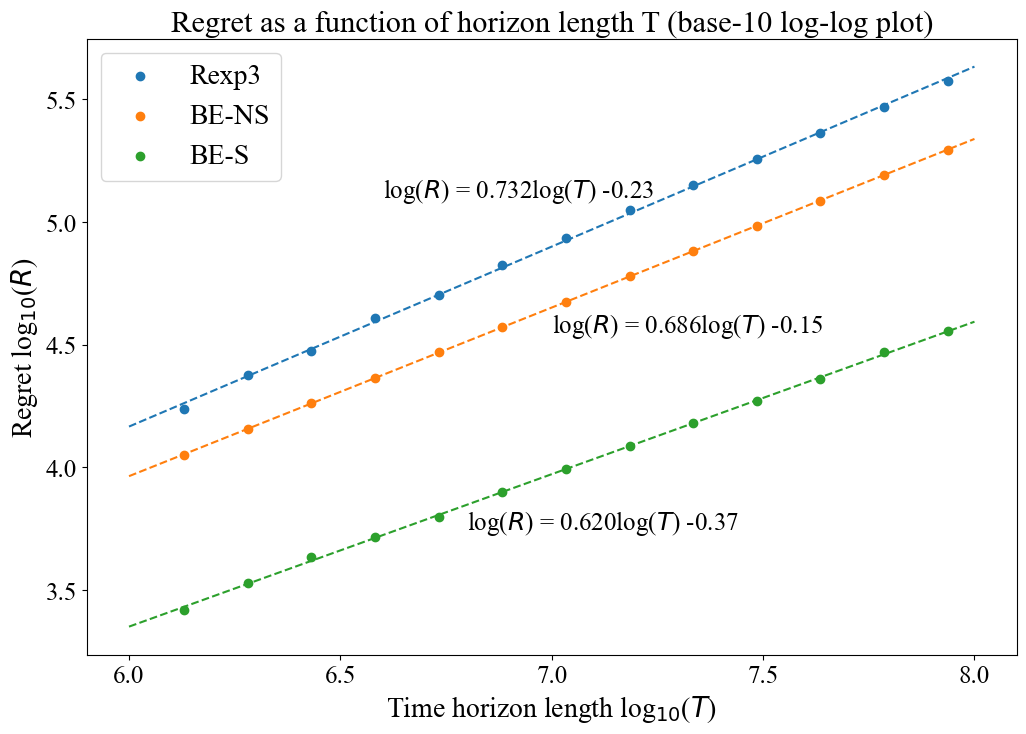

In [29]:
x = np.append(np.log10(86400000/2**np.arange(6,-1,-1)), np.log10(61094026/2**np.arange(5,-1,-1)))
y = np.append(np.log10(regrets[20:]), np.log10(sqrt_regrets[20:]))
y1 = np.append(np.log10(regrets1[20:]), np.log10(sqrt_regrets1[20:]))
y2 = np.append(np.log10(regrets2[20:]), np.log10(sqrt_regrets2[20:]))

# Perform linear regression to find the best-fit line
slope, intercept = np.polyfit(x, y, 1)
slope1, intercept1 = np.polyfit(x, y1, 1)
slope2, intercept2 = np.polyfit(x, y2, 1)

# Use Times New Roman font for LaTeX rendering
rc('font', family='Times New Roman')

# Plot the data points and the best-fit lines
plt.gcf().set_size_inches(12, 8)

plt.scatter(x, y, label="Rexp3")
plt.scatter(x, y1, label="BE-NS")
plt.scatter(x, y2, label="BE-S")
plt.legend(fontsize=20)

x_extended = np.arange(6,8.5,0.5)
line, = plt.plot(x_extended, slope * x_extended + intercept, '--', label="log($R$) = {:.3f}log($T$) {:.2f}".format(slope, intercept))
line1, = plt.plot(x_extended, slope1 * x_extended + intercept1, '--', label="log($R$) = {:.3f}log($T$) {:.2f}".format(slope1, intercept1))
line2, = plt.plot(x_extended, slope2 * x_extended + intercept2, '--', label="log($R$) = {:.3f}log($T$) {:.2f}".format(slope2, intercept2))

# Manually position the legend near the best fit lines
plt.annotate(line.get_label(), xy=(6.7, 5.1), xytext=(6.6, 5.1), fontsize=18)
plt.annotate(line1.get_label(), xy=(7.0, 4.55), xytext=(7.0, 4.55), fontsize=18)
plt.annotate(line2.get_label(), xy=(6.8, 3.75), xytext=(6.8, 3.75), fontsize=18)


plt.xlabel('Time horizon length log$_{10}$($T$)', fontsize=20)
plt.ylabel('Regret log$_{10}$($R$)', fontsize=20)
plt.xticks(np.arange(6,8.5,0.5), fontsize=18)
plt.yticks(np.arange(3.5,6,0.5), fontsize=18)
plt.title("Regret as a function of horizon length T (base-10 log-log plot)", fontsize=22)

In [24]:
x

array([6.13033377, 6.43136376, 6.73239376, 7.03342376, 7.33445375,
       7.63548375, 7.93651374, 6.28084877, 6.58187876, 6.88290876,
       7.18393875, 7.48496875, 7.78599875])

In [25]:
y

array([4.23686199, 4.47341631, 4.7024703 , 4.93221508, 5.14825103,
       5.36048393, 5.57086115, 4.37444219, 4.60865723, 4.82455138,
       5.04843578, 5.25440825, 5.46636033])

In [26]:
y1

array([4.05249416, 4.2603354 , 4.46841344, 4.67497894, 4.88083535,
       5.08560785, 5.2920465 , 4.15490288, 4.36423143, 4.57226486,
       4.77830978, 4.9824353 , 5.18995962])

In [27]:
y2

array([3.42118054, 3.63386076, 3.79978501, 3.99365623, 4.17978841,
       4.3589965 , 4.55353787, 3.53006493, 3.71676429, 3.89803676,
       4.08787085, 4.27025258, 4.46858915])

In [77]:
slope

0.7324506486379523

In [56]:
slope1

0.6862587951982002

In [57]:
slope2

0.6204928668262187

In [27]:
opt_rewards

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.22469066e+03,
       4.44933440e+03, 8.89866498e+03, 1.77973261e+04, 3.55946484e+04,
       7.11892930e+04, 1.42378582e+05, 2.84757160e+05, 5.69514317e+05,
       1.13902863e+06, 2.27805726e+06, 4.55611451e+06])